All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p.262:
> In this exercise, we will generate simulated data, and will then use
this data to perform best subset selection.

In [75]:
from itertools import combinations

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler


pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
sns.set()

# (a)

From the textbook, p. 262:
> Use the `rnorm()` function to generate a predictor $X$ of length $n = 100$, as well as a noise vector $\varepsilon$ of length $n = 100$.

In [76]:
np.random.seed(1)
x = np.random.normal(size=100)
eps = np.random.normal(size=100)

# (b)

From the textbook, p. 262:
> Generate a response vector $Y$ of length $n = 100$ according to the model $Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \varepsilon$, where $\beta_0, \beta_1, \beta_2, \beta_3$ are constants of your choice.

In [77]:
beta = np.random.randint(low=1, high=10, size=4)
print(beta)
xx = x ** np.arange(4).reshape(-1, 1)
y = beta @ xx + eps

[9 8 1 6]


# (c)

From the textbook, p. 262:
> Use the `regsubsets()` function to perform best subset selection in order to choose the best model containing the predictors $X, X^2 , \dots, X^{10}$. What is the best model obtained according to $C_p$ , $BIC$, and adjusted $R^2$? Show some plots to provide evidence for your answer, and report the coefficients of the best model obtained. Note you will need to use the `data.frame()` function to create a single data set containing both $X$ and $Y$.

`sklearn` does not have anything like R's `regsubsets()`. Thankfully, people on StackOverflow [solved](https://stackoverflow.com/questions/22956938/exhaustively-feature-selection-in-scikit-learn) this for me, at least partly. I'm calculating $C_p$ and $BIC$ as described in these articles on Wikipedia: [Mallow's Cp](https://en.wikipedia.org/wiki/Mallows%27s_Cp), [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion#Gaussian_special_case).

In [78]:
def get_reg_params(X, y, estimator, subset):
  """Returns regression metrics that are necessary to calculate
     Cp, BIC, adjusted R^2.
  """
     
  estimator.fit(X, y)
  pred = estimator.predict(X)
  rss_full = sum((y - pred)**2)
  estimator.fit(X[:, list(subset)], y)
  pred = estimator.predict(X[:, list(subset)])
  rss = sum((y - pred)**2)
  tss = sum((y - y.mean())**2)
  n = X.shape[0]
  d = len(list(subset))
  rms = rss_full / n  # residual mean squares
  return rss, tss, rms, n, d

def adjusted_R2(X, y, estimator, subset):
  rss, tss, _, n, d = get_reg_params(X, y, estimator, subset)
  return 1 - rss*(n - 1) / tss / (n - d - 1)

def mallow_cp(X, y, estimator, subset):
  rss, _, rms, n, d = get_reg_params(X, y, estimator, subset)
  return rss/rms - n + 2*(d + 1)

def bic(X, y, estimator, subset):
  rss, _, _, n, d = get_reg_params(X, y, estimator, subset)
  return n*np.log(rss/n) + d*np.log(n)

def best_in_size(X, y, estimator, subsets_k):
  best_score = -np.inf
  best_subset = []
  for subset in subsets_k: # for each subset
    subset = list(subset)
    estimator.fit(X[:, list(subset)], y)
    # get the subset with the best score among subsets of the same size
    score = estimator.score(X[:, list(subset)], y)
    if score > best_score:
      best_score, best_subset = score, subset
  return best_subset


def subset_selection(X, y, estimator, score_func, method):
  """Calculates the best model of up to max_size features of X.
     estimator must have a fit and score functions.
     X must be a DataFrame.
  """

  n_features = X.shape[1]
  exhaustive_subsets = (combinations(range(n_features), k + 1) 
                        for k in range(n_features)
  )
  # Initializations:
  all_predictors = list(range(n_features))

  if method == 'forward':
    best_subset = []
  elif method == 'backward':
    best_subset = all_predictors.copy()

  best_size_subset = [all_predictors] if method == 'backward' else []

  if method == 'exhaustive':
    for subsets_k in exhaustive_subsets:
      best_subset = best_in_size(X, y, estimator, subsets_k)
      best_size_subset.append(best_subset)

  elif method == 'forward':
    for i in range(n_features):
      to_check = set(all_predictors) - set(best_subset)
      subsets_k = [list(best_subset) + [var] for var in to_check]
      best_subset = best_in_size(X, y, estimator, subsets_k)
      best_size_subset.append(best_subset)

  elif method == 'backward':
    for i in range(n_features-1):
      to_check = list(best_subset)
      subsets_k = []
      for each in to_check:
        lst = list(best_subset)
        lst.remove(each)
        subsets_k.append(lst)
      best_subset = best_in_size(X, y, estimator, subsets_k)
      best_size_subset.append(best_subset)

  # compare best subsets of each size
  subsets = []
  scores = []
  for subset in best_size_subset:
    score = score_func(X, y, estimator, subset)
    subset = tuple(subset)
    subsets.append(subset)
    scores.append(score)

  return subsets, scores

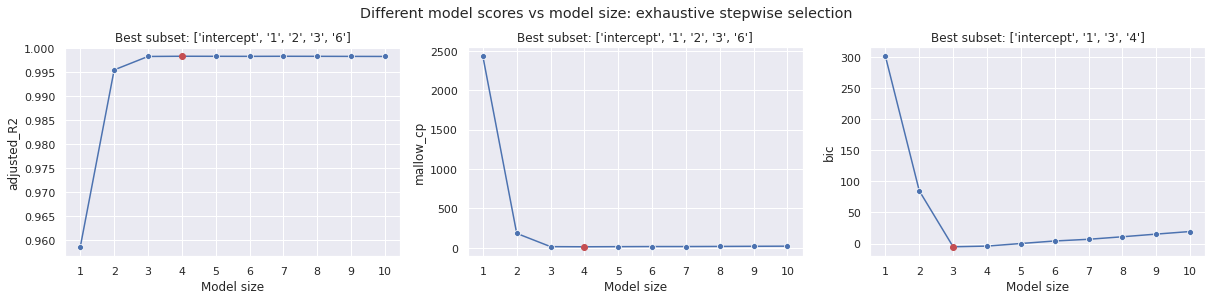

In [79]:
x_matrix = x ** np.arange(1, 11).reshape(-1, 1)
x_matrix = x_matrix.T
estimator = LinearRegression()

def subset_criteria_plots(X, y, estimator, method):
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 4))
  axs = axs.flatten()
  table_cols = []
  for ax, score_func in zip(axs, [adjusted_R2, mallow_cp, bic]):
    subsets, scores = subset_selection(X, y, estimator, score_func, method=method)
    model_sizes = [len(subset) for subset in subsets]
    best_score = max(scores) if score_func is adjusted_R2 else min(scores)
    best_score_idx = scores.index(best_score)
    best_size = model_sizes[best_score_idx]
    best_subset = sorted(subsets[best_score_idx])
    estimator = estimator.fit(x_matrix[:, best_subset], y)
    coefs = np.append(estimator.intercept_, estimator.coef_)
    coefs = [f'{c:.2f}' for c in coefs]
    best_subset = ['intercept'] + [str(b + 1) for b in best_subset]
    sns.lineplot(x=model_sizes
                 , y=scores
                 , ax=ax
                 , marker='o'
                )
    ax.plot(best_size, best_score, 'ro')
    ax.set_title(f'Best subset: {best_subset}')
    ax.set_xticks(model_sizes)
    ax.set_xlabel('Model size')
    ax.set_ylabel(score_func.__name__)
    table_cols.append((method, score_func.__name__, best_size, best_subset, coefs))

  fig.suptitle(f'Different model scores vs model size: {method} stepwise selection', y=1.04)
  plt.tight_layout()
  plt.show()
  return pd.DataFrame(table_cols, columns=['method', 'criterion', 'best_size', 'best_subset', 'coefs'])

exhaustive_table = subset_criteria_plots(x_matrix, y, estimator, 'exhaustive')

All three plots show that, with `model_size` above 3, the differences in the criteria are minor. Adjusted $R^2$ and Mallow's $C_p$ chose the same subset of predictors with size 4; $BIC$ chose differently.

# (d)

From the textbook, p. 263:
> Repeat (c), using forward stepwise selection and also using backwards stepwise selection. How does your answer compare to the results in (c)?

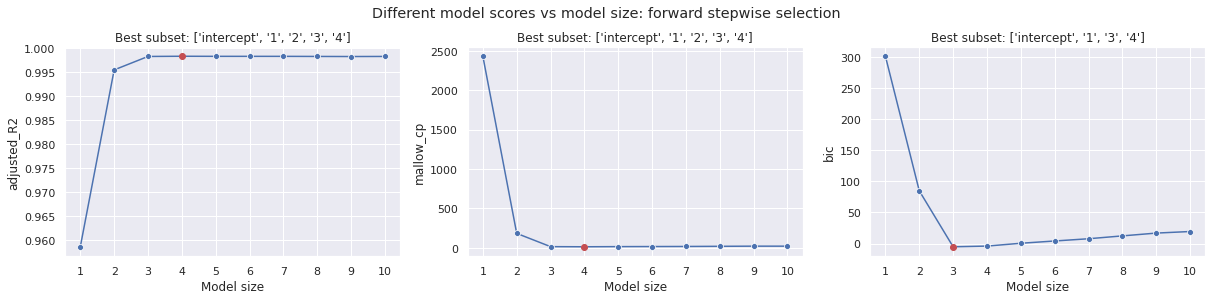

In [80]:
forward_table = subset_criteria_plots(x_matrix, y, estimator, 'forward')

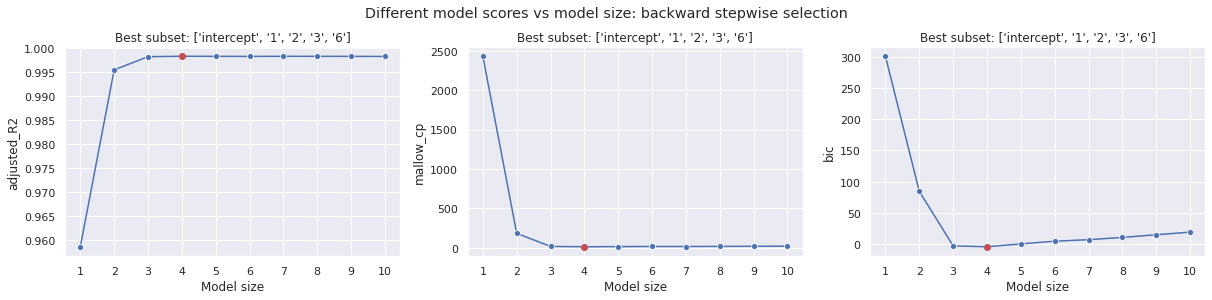

In [81]:
backward_table = subset_criteria_plots(x_matrix, y, estimator, 'backward')

In [82]:
pd.concat(
    [exhaustive_table
     , forward_table
     , backward_table
    ]
).set_index(['method', 'criterion'])

best_size  ...                           coefs
method     criterion               ...                                
exhaustive adjusted_R2          4  ...  [9.28, 7.91, 0.66, 6.11, 0.02]
           mallow_cp            4  ...  [9.28, 7.91, 0.66, 6.11, 0.02]
           bic                  3  ...        [9.49, 7.93, 6.11, 0.24]
forward    adjusted_R2          4  ...  [9.31, 7.91, 0.46, 6.10, 0.14]
           mallow_cp            4  ...  [9.31, 7.91, 0.46, 6.10, 0.14]
           bic                  3  ...        [9.49, 7.93, 6.11, 0.24]
backward   adjusted_R2          4  ...  [9.28, 7.91, 0.66, 6.11, 0.02]
           mallow_cp            4  ...  [9.28, 7.91, 0.66, 6.11, 0.02]
           bic                  4  ...  [9.28, 7.91, 0.66, 6.11, 0.02]

[9 rows x 3 columns]

Backward selection matches exhaustive selection when using adjusted $R^2$ and Mallow's $C_p$; forward selection matches exhaustive selection when using $BIC$.

Original regression coefficients were \[9, 8, 1, 6\]. Ideally, the process should select \[intercept, 1, 2, 3\] as best subset and fit a regression with \[9, 8, 1, 6\]. The closest results I get have variables \[intercept, 1, 2, 3, 6\] with coefficients \[9.28, 7.91, 0.66, 6.11, 0.02\]. I think, this happens because the noise is quite large: $\epsilon$ has the same mean and variance as $x$. When I set $\epsilon$ to zero, all 9 options get the same (correct) result. (This is also how I checked whether my model selection process was working at all.)

# (e)

From the textbook, p. 263:
> Now fit a lasso model to the simulated data, again using $X, X^2, \dots , X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained.

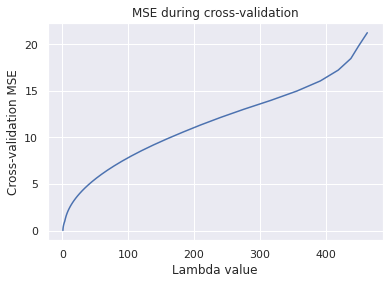

Optimal lambda value 0.02124890595005359
Regression coefficients: ['11.26', '7.00', '0.51', '15.51', '0.63', '0.00', '0.01', '0.00', '0.00', '0.00', '0.00']


In [84]:
model_e = LassoCV(max_iter=30000)
scaler = StandardScaler().fit(x_matrix)
x_scaled = scaler.transform(x_matrix)
model_e.fit(x_scaled, y)
coefs = [f'{c:.2f}' for c in np.append(model_e.intercept_, model_e.coef_)]
sns.lineplot(x=model_e.mse_path_.mean(axis=1), y=model_e.alphas_)
plt.xlabel('Lambda value')
plt.ylabel('Cross-validation MSE')
plt.title('MSE during cross-validation')
plt.show()
print('Optimal lambda value', model_e.alpha_)
print('Regression coefficients:', coefs)

The coefficients are off. I suppose, this happened because of the standardization of predictors.

I derived the following formulas to "unscale" the betas:
$$\beta_0 = \beta'_0 - \sum_{i=1}^p \frac{\beta'_i \bar{x}_i}{\sigma_i}$$
$$\beta_i = \frac{\beta'_i}{\sigma_i}, \; i = 1..p$$
where $p$ is the number of predictors.

In [94]:
def unscale(model, scaler):
  unscaled_beta = model.coef_ / scaler.scale_
  unscaled_intercept = model.intercept_ - sum(model.coef_ * scaler.mean_ / scaler.scale_)
  return unscaled_intercept, unscaled_beta

unscale(model_e, scaler)

(9.321873242641301,
 array([7.90793135e+00, 4.62329980e-01, 6.09166264e+00, 1.31618560e-01,
        0.00000000e+00, 3.80107059e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]))

The ideal coefficients' values are \[9, 8, 1, 6\]. Here I have \[9.32, 7.91, 0.46, 6.09, 0.13\]. This is almost the same model that I got using stepwise forward selection with adjusted $R^2$ and Mallow's $C_p$.

# (f)

From the textbook, p. 263:
> Now generate a response vector $Y$ according to the model $Y = \beta_0 + \beta_7 X^7 + \varepsilon$, and perform best subset selection and the lasso. Discuss the results obtained.

(9.181612666145114, array([ 0.        ,  0.        , -0.        ,  0.        , -0.93717585,
        0.        , -3.51228811,  0.        , -0.0587574 ,  0.        ]))


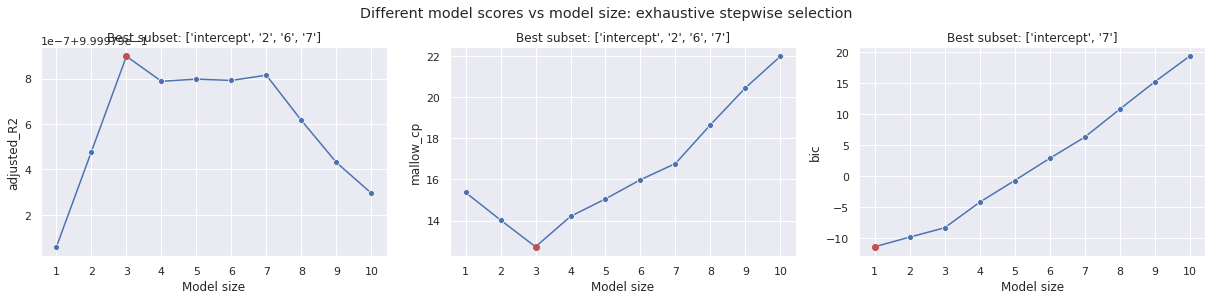

,method,criterion,best_size,best_subset,coefs
0,exhaustive,adjusted_R2,3,"[intercept, 2, 6, 7]","[9.27, -0.32, 0.02, -4.00]"
1,exhaustive,mallow_cp,3,"[intercept, 2, 6, 7]","[9.27, -0.32, 0.02, -4.00]"
2,exhaustive,bic,1,"[intercept, 7]","[9.15, -4.00]"


In [95]:
y = 9 - 4*x**7 + eps
lasso_f = LassoCV(max_iter=30000)
lasso_f.fit(x_scaled, y)
print(unscale(lasso_f, scaler))

subset_criteria_plots(x_matrix, y, LinearRegression(), 'exhaustive')

Lasso result: \[9.18, 0, 0, 0, 0, -0.94, 0, -3.51, 0, -0.06\]. $\beta_0$ is good, $\beta_7$ is reasonable, $\beta_5$ is quite bad, $\beta_9$ is reasonable. The latter two should be zeros.

Best subset selection result:
* $BIC$ just nailed it with 9.15 and -4 for correspondent predictors;
* adjusted $R^2$ and Mallow's $C_p$ give the same model. The model gets $beta_7$ correctly, $\beta_0$ is reasonably close, but $\beta_2$ and $\beta_6$ should be zeros (although they both are quite close to zero).